## 1 权重衰减
### 1.1 理论模型
应对过拟合的方法是**正则化**。以线性回归问题为例，默认的均方误差为
$$
l(w_1, w_2, b) = \frac{1}{n} \sum_{i=1}^n \frac{1}{2} \bigg( x_1^{(i)}w_1 + x_2^{(i)}w_2 + b - y^{(i)} \bigg)^2,
$$
若加上$L_2$范数惩罚项，则得到新损失函数：
$$
l(w_1, w_2, b) + \frac{\lambda}{2n} \Vert \vec{w} \Vert^2.
$$
很容易计算，若对新损失函数求$\vec{w}$的偏导，则可以得到$\vec{w}$的更新公式为
$$
w_1 \leftarrow \bigg( 1 - \frac{\eta \lambda}{|\mathcal{B}|} \bigg) w_1 - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} x_1^{(i)} \bigg( x_1^{(i)}w_1 + x_2^{(i)}w_2 + b - y^{(i)} \bigg)\\
w_2 \leftarrow \bigg( 1 - \frac{\eta \lambda}{|\mathcal{B}|} \bigg) w_2 - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} x_2^{(i)} \bigg( x_1^{(i)}w_1 + x_2^{(i)}w_2 + b - y^{(i)} \bigg),
$$
这相当于是令权重先自乘小于$1$的数，再减去不含惩罚项的梯度。因此，$L_2$范数正则化又叫权重衰减。

### 1.2 高维线性回归实验
设样本特征为$p$维，样本的标签根据下式生成：
$$
y = 0.05 + \sum_{i=1}^p 0.01 x_i + \epsilon,
$$
其中$\epsilon \sim \mathcal{N}(\mu=0, \sigma=0.01)$。

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import my_utils

# 训练样本少，主动制造过拟合环境。p = 200
n_train, n_test, num_inputs =  20, 100, 200
true_w, true_b = torch.ones(num_inputs, 1) * 0.01, 0.05

features = torch.randn((n_train + n_test, num_inputs))
labels = torch.matmul(features, true_w) + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)
train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

#### 1.2.1 权重衰减的从零开始实现

初始化模型参数：

In [2]:
def init_params():
    w = torch.randn((num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

定义L2正则化项：

In [3]:
def l2_penalty(w):
    return (w**2).sum() / 2

定义带有$L_2$范数正则化项的训练模型：

In [5]:
batch_size, num_epochs, lr = 1, 100, 0.003
net, loss = my_utils.linreg, my_utils.squared_loss

dataset = torch.utils.data.TensorDataset(train_features, train_labels)
train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

def fit_and_plot(lambd):
    w, b = init_params()
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X, w, b), y) + lambd * l2_penalty(w)
            l = l.sum()
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            l.backward()
            my_utils.mgd([w, b], lr, batch_size)
        train_ls.append(loss(net(train_features, w, b), train_labels).mean().item())
        test_ls.append(loss(net(test_features, w, b), test_labels).mean().item())
    
    my_utils.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss', 
                     range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2-norm of w:', w.norm().item())

观察权重衰减对结果的影响：

L2-norm of w: 13.236729621887207


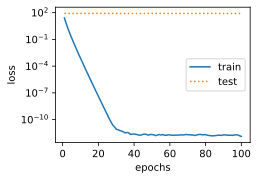

In [6]:
fit_and_plot(lambd=0)

L2-norm of w: 0.028186438605189323


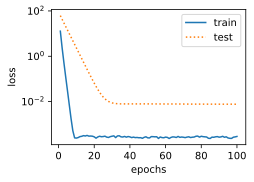

In [8]:
fit_and_plot(lambd=3)

#### 1.2.2 权重衰减的PyTorch实现
直接在定义参数时需要执行权重衰减的参数的weight_decay属性设置为$\lambda$的值。

In [13]:
def fit_and_plot_torch(lambd):
    net = nn.Linear(num_inputs, 1)
    nn.init.normal_(net.weight, mean=0, std=0.01)
    nn.init.normal_(net.bias, mean=0, std=0.01)
    # 因为我们不对b设置weight_decay，因此需要分别进行优化
    optimizer_w = torch.optim.SGD(params=[net.weight], lr=lr, weight_decay=lambd)
    optimizer_b = torch.optim.SGD(params=[net.bias], lr=lr)
    
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y).mean()
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()
            l.backward()
            optimizer_w.step()
            optimizer_b.step()
        train_ls.append(loss(net(train_features), train_labels).mean().item())
        test_ls.append(loss(net(test_features), test_labels).mean().item())
    my_utils.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss', 
                     range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2-norm of w:', net.weight.data.norm().item())

观察权重衰减对结果的影响：

L2-norm of w: 0.13679169118404388


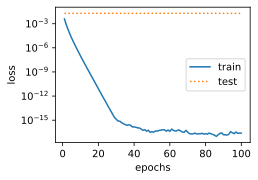

In [14]:
fit_and_plot_torch(0)

L2-norm of w: 0.017953433096408844


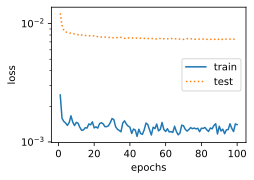

In [18]:
fit_and_plot_torch(10)